In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [132]:
df_train = pd.read_csv("./train.csv/train.csv",nrows=50000)
df_train.head()
df_train.info()
df_train.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                50000 non-null  object 
 1   fare_amount        50000 non-null  float64
 2   pickup_datetime    50000 non-null  object 
 3   pickup_longitude   50000 non-null  float64
 4   pickup_latitude    50000 non-null  float64
 5   dropoff_longitude  50000 non-null  float64
 6   dropoff_latitude   50000 non-null  float64
 7   passenger_count    50000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 3.1+ MB


(50000, 8)

In [133]:
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,11.364171,-72.509756,39.933759,-72.504616,39.926251,1.667840
std,9.685557,10.393860,6.224857,10.407570,6.014737,1.289195
min,-5.000000,-75.423848,-74.006893,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992062,40.734880,-73.991152,40.734372,1.000000
50%,8.500000,-73.981840,40.752678,-73.980082,40.753372,1.000000
75%,12.500000,-73.967148,40.767360,-73.963584,40.768167,2.000000
max,200.000000,40.783472,401.083332,40.851027,43.415190,6.000000


In [134]:
df_train.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [135]:
df_train.dropna(inplace=True, axis=0)
df_train.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [136]:
print(len(df_train[df_train["pickup_longitude"]==0]))

955


In [137]:
df_train = df_train.drop(df_train[df_train["pickup_longitude"]==0].index)

In [138]:
df_train['pickup_datetime'] = pd.to_datetime(df_train['pickup_datetime'])

In [139]:
df_train.loc[:,'pickup_date'] = df_train['pickup_datetime'].dt.day

In [140]:
df_train.loc[:, 'pickup_month'] = df_train['pickup_datetime'].dt.month
df_train.loc[:, 'pickup_year'] = df_train['pickup_datetime'].dt.year

In [141]:
df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,pickup_month,pickup_year
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,15,6,2009
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,5,1,2010
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,18,8,2011
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,21,4,2012
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,9,3,2010


In [142]:
# Haversine distance 
from math import cos, asin, sqrt, pi

def distance(lat1, lon1, lat2, lon2):
    r = 6371
    p = pi / 180

    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 2 * r * asin(sqrt(a))

df_train["Haversine_distance"] = df_train.apply(lambda row: distance(row['pickup_latitude'],row['pickup_longitude'],row['dropoff_latitude'],row['dropoff_longitude']), axis=1)


In [143]:
len(df_train)

49045

In [144]:
print(df_train['Haversine_distance'].median(),
df_train['Haversine_distance'].mean(),
df_train['Haversine_distance'].mode())

2.162233839130312 11.76349130528574 0    0.0
Name: Haversine_distance, dtype: float64


In [145]:
# import osmnx as ox
# import networkx as nx

In [146]:
# This is to save the NY map as a graph I think
# city = [
#     {
#         "city": "New York",
#         "state": "New York",
#         "country": "USA",
#     }
# ]
# NY_graph = ox.graph_from_place(city, network_type='drive')

In [147]:
# NY_graph2 = ox.graph_from_place('New York, USA', network_type='drive_service')

In [148]:
# ox.save_graphml(NY_graph, 'NY1.graphml')
# ox.save_graphml(NY_graph2, 'NY2.graphml')

In [149]:
# import os
# 
# # print(os.path.isfile("./NY1.graphml") and  os.path.isfile("./NY2.graphml"))
# 
# if not (os.path.isfile("./NY1.graphml") and os.path.isfile("./NY2.graphml")):
#     city = [
#         {
#             "city": "New York",
#             "state": "New York",
#             "country": "USA",
#         }
#     ]
#     NY_graph = ox.graph_from_place(city, network_type='drive')
#     ox.save_graphml(NY_graph, 'NY1.graphml')
# 
#     NY_graph2 = ox.graph_from_place('New York, USA', network_type='drive_service')
#     ox.save_graphml(NY_graph2, 'NY2.graphml')
# 
#     print("Graphs GENERATED successfully")
# else:
#     NY_graph = ox.load_graphml('NY1.graphml')
#     NY_graph2 = ox.load_graphml('NY2.graphml')
#     print("Graphs LOADED successfully")

In [150]:
# NY_graph
# NY_graph2

In [151]:
# start_graph_node = ox.utils.get_nearest_node(NY_graph,(40.767937, -73.982155))
# end_graph_node = ox.utils.get_nearest_node(NY_graph,(40.765602, -73.964630))

# get_nearest_node is deprecated i think

In [152]:
# start_graph_node = ox.nearest_nodes(NY_graph,-73.982155,40.767937 ,return_dist=True)
# end_graph_node = ox.nearest_nodes(NY_graph,-73.982155,40.765602,return_dist=True)

# Syntax: nearest_nodes(graph_obj, longitude value, latitude value, if we want the distance or not)

In [153]:
# import folium

# m = ox.plot_graph_folium(NY_graph)
# m.save('NY1.html')

# m2 = ox.plot_graph_folium(NY_graph2)
# m2.save('NY2.html')

# folium is bad use GeoPanda or smthng
# import geopandas as gpd

In [154]:
# THIS METHOD IS IRRELEVANT TAKES TOO MUCH TIME
# from functools import lru_cache
# 
# noPathCounter = 0
# @lru_cache(maxsize=10000)
# def get_road_dist(graph_obj, long1, lat1, long2, lat2):
#     global noPathCounter
#     start_graph_node,start_node_dist = ox.nearest_nodes(graph_obj,long1,lat1,return_dist=True)
#     end_graph_node,end_node_dist = ox.nearest_nodes(graph_obj,long2,lat2,return_dist=True)
# 
#     # distance = ox.shortest_path(graph_obj,start_graph_node,end_graph_node,weight="length", )
#     try:
#         shortest_distance = nx.shortest_path_length(graph_obj,start_graph_node,end_graph_node)
#         # print("shortest path found for node:",start_graph_node,end_graph_node)
#         return shortest_distance +start_node_dist + end_node_dist
#     except nx.NetworkXNoPath as noPathError:
#         shortest_distance = None
#         noPathCounter +=1
#         print(noPathError)
#         return shortest_distance
# 
# df_train["osmnx_distance"] = df_train.apply(lambda row: get_road_dist(NY_graph,row["pickup_longitude"],row["pickup_latitude"],row["dropoff_longitude"],row["dropoff_latitude"]), axis=1)
# df_train.head()

In [155]:
# import requests

# def get_road_dist(row):
#     start_lon, start_lat = row["pickup_longitude"], row["pickup_latitude"]
#     end_lon, end_lat = row["dropoff_longitude"], row["dropoff_latitude"]
#     
#     url = "http://router.project-osrm.org/route/v1/driving/"
#     coords = f"{start_lon},{start_lat};{end_lon},{end_lat}"
#     params = {
#         "geometries": "polyline",
#         "overview": "full",
#         "steps": "true"
#     }
#     
#     try:
#         response = requests.get(url + coords, params=params)
#         response.raise_for_status()
#         data = response.json()
#         
#         if data["code"] == "Ok" and data["routes"]:
#             return data["routes"][0]["distance"]
#         else:
#             print(f"Error: {data['message']}")
#             return None
#     except requests.exceptions.RequestException as e:
#         print(f"Error: {e}")
#         return None
# 
# 
# df_train["osrm_dist"] = df_train.apply(get_road_dist, axis=1)

In [156]:
# import requests
# from itertools import islice
# from functools import lru_cache
# 
# BATCH_SIZE = 200 
# CACHE_SIZE = 10000 
# 
# @lru_cache(maxsize=CACHE_SIZE)
# def get_road_dist_cached(start_lon, start_lat, end_lon, end_lat):
#     url = "http://router.project-osrm.org/route/v1/driving/"
#     coords = f"{start_lon},{start_lat};{end_lon},{end_lat}"
#     params = {
#         "geometries": "polyline",
#         "overview": "full",
#         "steps": "true"
#     }
# 
#     try:
#         response = requests.get(url + coords, params=params)
#         response.raise_for_status()
#         data = response.json()
# 
#         if data["code"] == "Ok" and data["routes"]:
#             return data["routes"][0]["distance"]
#         else:
#             print(f"Error: {data['message']}")
#             return None
#     except requests.exceptions.RequestException as e:
#         print(f"Error: {e}")
#         return None
# 
# def batch(iterable, batch_size):
#     iterator = iter(iterable)
#     while True:
#         batch = list(islice(iterator, batch_size))
#         if not batch:
#             break
#         yield batch
# 
# def get_road_dist_batch(coords):
#     distances = []
#     for start_lon, start_lat, end_lon, end_lat in coords:
#         distance = get_road_dist_cached(start_lon, start_lat, end_lon, end_lat)
#         distances.append(distance)
# 
#     return distances
# 
# coords = list(df_train[["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]].itertuples(index=False, name=None))
# df_train["osrm_dist"] = get_road_dist_batch(coords)

In [157]:
# import requests
# from itertools import islice
# from functools import lru_cache
# import time
# 
# BATCH_SIZE = 100  
# CACHE_SIZE = 10000
# SLEEP_TIME = 1  # Sleep time between batches to avoid rate limiting
# 
# @lru_cache(maxsize=CACHE_SIZE)
# def get_road_dist_cached(start_lon, start_lat, end_lon, end_lat):
#     url = "http://router.project-osrm.org/route/v1/driving/"
#     coords = f"{start_lon},{start_lat};{end_lon},{end_lat}"
#     params = {
#         "geometries": "polyline",
#         "overview": "full",
#         "steps": "true"
#     }
# 
#     try:
#         response = requests.get(url + coords, params=params)
#         response.raise_for_status()
#         data = response.json()
# 
#         if data["code"] == "Ok" and data["routes"]:
#             distance = data["routes"][0]["distance"]
#         else:
#             print(f"Error: {data['message']}")
#             distance = None
# 
#         return distance
#     except requests.exceptions.RequestException as e:
#         print(f"Error: {e}")
#         return None
# 
# def batch(iterable, batch_size):
#     iterator = iter(iterable)
#     while True:
#         batch = list(islice(iterator, batch_size))
#         if not batch:
#             break
#         yield batch
# 
# def get_road_dist_batch(coords):
#     distances = []
#     total_batches = len(coords) // BATCH_SIZE
#     start_time = time.time()
#     for i, coord_batch in enumerate(batch(coords, BATCH_SIZE), 1):
#         batch_start_time = time.time()
#         for start_lon, start_lat, end_lon, end_lat in coord_batch:
#             distance = get_road_dist_cached(start_lon, start_lat, end_lon, end_lat)
#             distances.append(distance)
#         batch_time = time.time() - batch_start_time
#         print(f"Batch {i}/{total_batches} time: {batch_time:.2f} seconds")
#         time.sleep(SLEEP_TIME)  # Sleep to avoid hitting rate limits
#     total_time = time.time() - start_time
#     print(f"Total time for {total_batches} batches: {total_time:.2f} seconds")
#     return distances
# 
# coords = list(df_train[["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]].itertuples(index=False, name=None))
# df_train["osrm_dist"] = get_road_dist_batch(coords)

In [158]:
# import requests
# import pandas as pd
# from concurrent.futures import ThreadPoolExecutor, as_completed
# import time
# import hashlib
# 
# # Initialize a cache
# cache = {}
# 
# def get_road_dist(start_lon, start_lat, end_lon, end_lat):
#     # Create a unique key for the route using hashing for efficiency
#     route_key = hashlib.md5(f"{start_lon},{start_lat},{end_lon},{end_lat}".encode()).hexdigest()
# 
#     # Check if the distance is already in the cache
#     if route_key in cache:
#         return cache[route_key]
# 
#     url = "http://router.project-osrm.org/route/v1/driving/"
#     coords = f"{start_lon},{start_lat};{end_lon},{end_lat}"
#     params = {
#         "geometries": "polyline",
#         "overview": "full",
#         "steps": "true"
#     }
# 
#     try:
#         response = requests.get(url + coords, params=params)
#         response.raise_for_status()
#         data = response.json()
# 
#         if data["code"] == "Ok" and data["routes"]:
#             distance = data["routes"][0]["distance"]
#             # Save the distance in the cache
#             cache[route_key] = distance
#             return distance
#         else:
#             print(f"Error: {data['message']}")
#             return None
#     except requests.exceptions.RequestException as e:
#         print(f"Error: {e}")
#         return None
# 
# def process_row(row):
#     start_time_row = time.time()
#     distance_osrm = get_road_dist(row["pickup_longitude"], row["pickup_latitude"], row["dropoff_longitude"], row["dropoff_latitude"])
#     end_time_row = time.time()
#     print("current row processing time: ", end_time_row - start_time_row)
#     return  distance_osrm
# 
# # Function to handle parallel processing
# def parallel_process(df, func, n_jobs=50):
#     results = []
#     with ThreadPoolExecutor(max_workers=n_jobs) as executor:
#         futures = [executor.submit(func, row) for _, row in df.iterrows()]
#         for future in as_completed(futures):
#             results.append(future.result())
#     return results
# 
# 
# # Apply the function to the dataframe with parallel processing
# start_time = time.time()
# df_train["osrm_dist"] = parallel_process(df_train, process_row, n_jobs=8)
# end_time = time.time()
# 
# print(df_train)
# print(f"Processing time: {end_time - start_time} seconds")

In [159]:
# import aiohttp
# import asyncio
# import hashlib
# import time
# 
# # Initialize a cache
# cache = {}
# 
# async def get_road_dist(session, start_lon, start_lat, end_lon, end_lat):
#     # Create a unique key for the route using hashing for efficiency
#     route_key = hashlib.md5(f"{start_lon},{start_lat},{end_lon},{end_lat}".encode()).hexdigest()
# 
#     # Check if the distance is already in the cache
#     if route_key in cache:
#         return cache[route_key]
# 
#     url = f"http://router.project-osrm.org/route/v1/driving/{start_lon},{start_lat};{end_lon},{end_lat}"
#     params = {
#         "geometries": "polyline",
#         "overview": "full",
#         "steps": "true"
#     }
# 
#     try:
#         async with session.get(url, params=params) as response:
#             data = await response.json()
#             if data["code"] == "Ok" and data["routes"]:
#                 distance = data["routes"][0]["distance"]
#                 # Save the distance in the cache
#                 cache[route_key] = distance
#                 return distance
#             else:
#                 print(f"Error: {data['message']}")
#                 return None
#     except aiohttp.ClientError as e:
#         print(f"Error: {e}")
#         return None
# 
# async def process_row(session, row):
#     start_time_row = time.time()
#     distance_osrm = await get_road_dist(session, row["pickup_longitude"], row["pickup_latitude"], row["dropoff_longitude"], row["dropoff_latitude"])
#     end_time_row = time.time()
#     print("Current row processing time: ", end_time_row - start_time_row)
#     return distance_osrm
# 
# async def main(df):
#     async with aiohttp.ClientSession() as session:
#         tasks = []
#         for _, row in df.iterrows():
#             tasks.append(process_row(session, row))
#         results = await asyncio.gather(*tasks)
#         return results
# 
# # Apply the function to the dataframe with asynchronous processing
# start_time = time.time()
# df_train["osrm_dist"] = await main(df_train)
# end_time = time.time()
# 
# print(df_train)
# print(f"Total processing time: {end_time - start_time} seconds")

In [160]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49045 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   key                 49045 non-null  object             
 1   fare_amount         49045 non-null  float64            
 2   pickup_datetime     49045 non-null  datetime64[ns, UTC]
 3   pickup_longitude    49045 non-null  float64            
 4   pickup_latitude     49045 non-null  float64            
 5   dropoff_longitude   49045 non-null  float64            
 6   dropoff_latitude    49045 non-null  float64            
 7   passenger_count     49045 non-null  int64              
 8   pickup_date         49045 non-null  int32              
 9   pickup_month        49045 non-null  int32              
 10  pickup_year         49045 non-null  int32              
 11  Haversine_distance  49045 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(6)

In [161]:
dataset_features = ['Haversine_distance','pickup_longitude','pickup_latitude','dropoff_latitude','dropoff_longitude','passenger_count','pickup_date','pickup_month','pickup_year']

X = df_train[dataset_features]
y = df_train['fare_amount']

In [162]:
from sklearn.tree import DecisionTreeRegressor

taxi_model = DecisionTreeRegressor(random_state=1)

taxi_model.fit(X,y)

DecisionTreeRegressor(random_state=1)

In [163]:
print("Original values for first 5 houses: \n")
print(df_train["fare_amount"].head(5))
print("Predictions for the first 5 houses: \n")
print(taxi_model.predict(X[:5]))

Original values for first 5 houses: 

0     4.5
1    16.9
2     5.7
3     7.7
4     5.3
Name: fare_amount, dtype: float64
Predictions for the first 5 houses: 

[ 4.5 16.9  5.7  7.7  5.3]


In [164]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

predicted_taxi_prices = taxi_model.predict(X)
mean_squared_error(y, predicted_taxi_prices)

0.0006524620246712203

In [165]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
taxi_model = DecisionTreeRegressor()
taxi_model.fit(X_train,y_train)

fare_predictions = taxi_model.predict(X_test)
print("MAE= ",mean_absolute_error(y_test, fare_predictions))
print("MSE= ",mean_squared_error(y_test, fare_predictions))

MAE=  2.6628188398409622
MSE=  25.65043897441125


In [166]:
def get_mae(max_leaf_nodes, train_X, train_y, test_X, test_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    predictions = model.predict(test_X)
    mae = mean_absolute_error(test_y, predictions)
    return mae

def get_mse(max_leaf_nodes, train_X, train_y, test_X, test_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X,train_y)
    predictions = model.predict(test_X)
    mse = mean_squared_error(test_y,predictions)
    return mse

def driver_function():
    for max_leaf_nodes in [5,10,50,100,500,1000,5000,10000]:
        mae = get_mae(max_leaf_nodes,X_train,y_train, X_test,y_test)
        mse = get_mse(max_leaf_nodes,X_train,y_train, X_test,y_test)
        print(f"Max Leaf Nodes: {max_leaf_nodes}\t MAE: {mae}\t MSE: {mse}")

driver_function()

Max Leaf Nodes: 5	 MAE: 2.9620737791871763	 MSE: 22.532784765700587
Max Leaf Nodes: 10	 MAE: 2.5992619477849623	 MSE: 19.629789750718267
Max Leaf Nodes: 50	 MAE: 2.222856903541269	 MSE: 16.738409174701843
Max Leaf Nodes: 100	 MAE: 2.1301344337085424	 MSE: 17.089717307645177
Max Leaf Nodes: 500	 MAE: 2.081392557953884	 MSE: 18.97872673523172
Max Leaf Nodes: 1000	 MAE: 2.132818497519049	 MSE: 20.746134746733365
Max Leaf Nodes: 5000	 MAE: 2.4370335013737017	 MSE: 24.351874396338186
Max Leaf Nodes: 10000	 MAE: 2.5953017127984968	 MSE: 25.296380190587552


In [167]:
from sklearn.ensemble import RandomForestRegressor

forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(X_train,y_train)
randomforest_predictions = forest_model.predict(X_test)
print("MAE for RandomForest: ", mean_absolute_error(y_test,randomforest_predictions))
print("MSE for Randomforest: ", mean_squared_error(y_test,randomforest_predictions))

MAE for RandomForest:  1.9450125666904539
MSE for Randomforest:  13.027735545075384


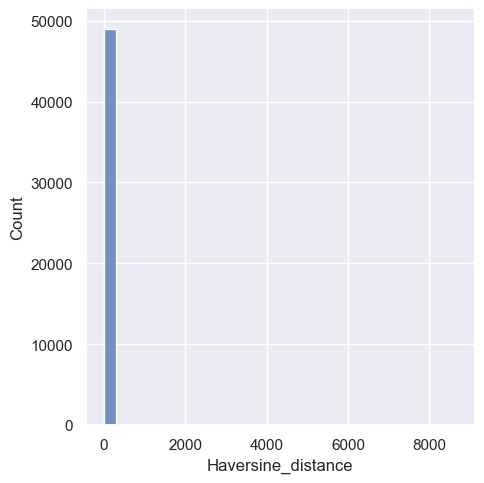

In [168]:
sns.set_theme()
sns.displot(data=df_train["Haversine_distance"], bins=30)

In [169]:
df_train["z_score"] = (
        (df_train["Haversine_distance"] - df_train["Haversine_distance"].mean()) / df_train["Haversine_distance"].std())
df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,pickup_month,pickup_year,Haversine_distance,z_score
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,15,6,2009,1.030764,-0.041089
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,5,1,2010,8.450134,-0.012685
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,18,8,2011,1.389525,-0.039715
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,21,4,2012,2.799270,-0.034318
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,9,3,2010,1.999157,-0.037381


In [170]:
print(len(df_train))
df_train_filtered = df_train[(df_train["z_score"]>-3) & (df_train["z_score"]<3)]
print(len(df_train_filtered))

49045
48993


In [171]:
IQR = df_train_filtered["Haversine_distance"].quantile(0.75) - df_train_filtered["Haversine_distance"].quantile(0.25)
print(IQR)

2.6780242518978166


In [172]:
df_train_filtered.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,pickup_month,pickup_year,Haversine_distance,z_score
count,48993.000000,48993.000000,48993.000000,48993.000000,48993.000000,48993.000000,48993.000000,48993.000000,48993.000000,48993.000000,48993.000000
mean,11.360809,-73.927622,40.712125,-73.926459,40.705343,1.669320,15.666748,6.273100,2011.739371,3.392666,-0.032047
std,9.657236,2.308100,2.796769,2.308152,2.274072,1.290317,8.659512,3.461119,1.865076,4.662224,0.017849
min,-5.000000,-75.423848,-74.006893,-75.354559,-74.006377,0.000000,1.000000,1.000000,2009.000000,0.000000,-0.045035
25%,6.000000,-73.992297,40.736471,-73.991327,40.735863,1.000000,8.000000,3.000000,2010.000000,1.262975,-0.040200
50%,8.500000,-73.982115,40.753414,-73.980471,40.754089,1.000000,16.000000,6.000000,2012.000000,2.159224,-0.036769
75%,12.500000,-73.968353,40.767757,-73.965267,40.768482,2.000000,23.000000,9.000000,2013.000000,3.940999,-0.029947
max,200.000000,40.783472,401.083332,40.851027,43.415190,6.000000,31.000000,12.000000,2015.000000,376.445536,1.396138


In [173]:
lower_limit = 1.262975
upper_limit = 3.940999

lower_limit = lower_limit - 1.5*IQR
upper_limit = upper_limit + 1.5*IQR

In [174]:
print(len(df_train_filtered))
df_train_filtered = df_train_filtered[ 
    (df_train_filtered["Haversine_distance"] >lower_limit) & (df_train_filtered["Haversine_distance"] < upper_limit) ]
print(len(df_train_filtered))

48993
44876


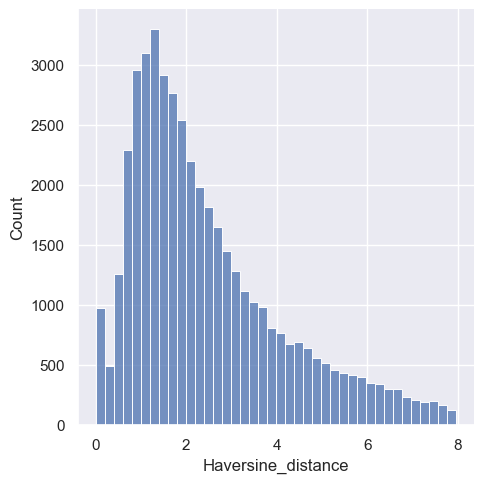

In [175]:
sns.displot(data=df_train_filtered["Haversine_distance"], bins=40)

In [176]:
df_train_filtered.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,pickup_month,pickup_year,Haversine_distance,z_score
count,44876.000000,44876.000000,44876.000000,44876.000000,44876.000000,44876.000000,44876.000000,44876.000000,44876.000000,44876.000000,44876.000000
mean,9.271572,-73.932799,40.706804,-73.931171,40.706960,1.666882,15.666548,6.263905,2011.730502,2.453706,-0.035641
std,5.691394,2.286753,2.249460,2.286900,2.249206,1.289384,8.667972,3.464351,1.865331,1.692498,0.006480
min,-5.000000,-75.414728,-74.006893,-75.354559,-74.006377,0.000000,1.000000,1.000000,2009.000000,0.000000,-0.045035
25%,5.700000,-73.992531,40.737312,-73.991624,40.737308,1.000000,8.000000,3.000000,2010.000000,1.201647,-0.040435
50%,8.000000,-73.982415,40.753366,-73.981252,40.754037,1.000000,16.000000,6.000000,2012.000000,1.976848,-0.037467
75%,11.300000,-73.970123,40.767098,-73.968015,40.767717,2.000000,23.000000,9.000000,2013.000000,3.298971,-0.032405
max,200.000000,40.783472,42.160275,40.851027,42.168717,6.000000,31.000000,12.000000,2015.000000,7.956803,-0.014573


In [177]:
lower_limit_pickup_long = -73.992531
upper_limit_pickup_long = -73.970123
lower_limit_pickup_lat = 40.737312
upper_limit_pickup_lat = 40.767098

lower_limit_dropoff_long = -73.991624
upper_limit_dropoff_long = -73.968015
lower_limit_droppff_lat = 40.737308
upper_limit_dropoff_lat = 40.767717

IQR_pickup_long = df_train_filtered["pickup_longitude"].quantile(0.75) - df_train_filtered["pickup_longitude"].quantile(0.25)
IQR_pickup_lat = df_train_filtered["pickup_latitude"].quantile(0.75) - df_train_filtered["pickup_latitude"].quantile(0.25)
IQR_dropoff_long = df_train_filtered["dropoff_longitude"].quantile(0.75) - df_train_filtered["dropoff_longitude"].quantile(0.25)
IQR_dropoff_lat = df_train_filtered["dropoff_latitude"].quantile(0.75) - df_train_filtered["dropoff_latitude"].quantile(0.25)
print(f"{IQR_pickup_long},{IQR_pickup_lat} \n {IQR_dropoff_long}, {IQR_dropoff_lat}")

lower_limit_pickup_long = lower_limit_pickup_long - 1.5*IQR_pickup_long
upper_limit_pickup_long = upper_limit_pickup_long + 1.5*IQR_pickup_long
lower_limit_pickup_lat = lower_limit_pickup_lat - 1.5*IQR_pickup_lat
upper_limit_pickup_lat = upper_limit_pickup_lat + 1.5*IQR_pickup_lat

lower_limit_dropoff_long = lower_limit_dropoff_long - 1.5*IQR_dropoff_long
upper_limit_dropoff_long = upper_limit_dropoff_long + 1.5*IQR_dropoff_long
lower_limit_droppff_lat = lower_limit_droppff_lat - 1.5*IQR_dropoff_lat
upper_limit_dropoff_lat = upper_limit_dropoff_lat + 1.5*IQR_dropoff_lat

print(len(df_train_filtered))
df_train_filtered = df_train_filtered[ 
    (df_train_filtered["pickup_longitude"] >lower_limit_pickup_long) & (df_train_filtered["pickup_longitude"] < upper_limit_pickup_long) ]
df_train_filtered = df_train_filtered[ 
    (df_train_filtered["pickup_latitude"] >lower_limit_pickup_lat) & (df_train_filtered["pickup_latitude"] < upper_limit_pickup_lat) ]
df_train_filtered = df_train_filtered[ 
    (df_train_filtered["dropoff_longitude"] >lower_limit_dropoff_long) & (df_train_filtered["dropoff_longitude"] < upper_limit_dropoff_long) ]
df_train_filtered = df_train_filtered[ 
    (df_train_filtered["dropoff_latitude"] >lower_limit_droppff_lat) & (df_train_filtered["dropoff_latitude"] < upper_limit_dropoff_lat) ]
print(len(df_train_filtered))

0.02240824999999802,0.02978635485839476 
 0.02360925000000691, 0.030409249999998167
44876
41837


In [178]:
lower_limit_percentile, upper_limit_percentile = np.percentile(a=df_train["Haversine_distance"],q=[0.5,99.5])
print(lower_limit_percentile, upper_limit_percentile)

0.0 21.67925433360676


In [179]:
print(len(df_train))
df_train_percentile_filtered = df_train[ (df_train["Haversine_distance"]>lower_limit_percentile) & (df_train["Haversine_distance"]<upper_limit_percentile) ]
print(len(df_train_percentile_filtered))

49045
48264


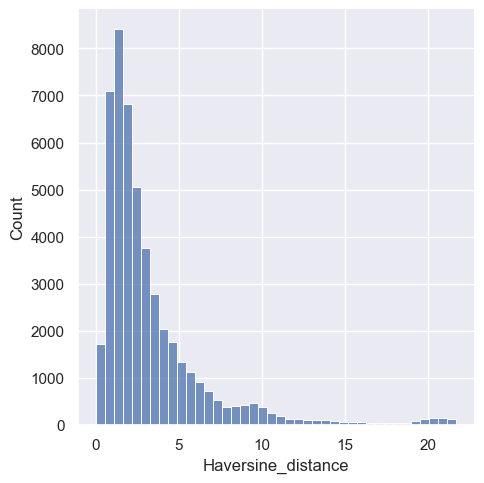

In [180]:
sns.displot(data=df_train_percentile_filtered["Haversine_distance"],bins=40)

In [181]:
# lower_limit_percentile_pickup_long, upper_limit_percentile_pickup_long = np.percentile(a=df_train["pickup_longitude"],q=[0.5,99.5])
# lower_limit_percentile_pickup_lat, upper_limit_percentile_pickup_lat = np.percentile(a=df_train["pickup_latitude"],q=[0.5,99.5])
# lower_limit_percentile_dropoff_long, upper_limit_percentile_dropoff_long = np.percentile(a=df_train["dropoff_longitude"],q=[0.5,99.5])
# lower_limit_percentile_dropoff_lat, upper_limit_percentile_dropoff_lat = np.percentile(a=df_train["dropoff_latitude"],q=[0.5,99.5])
# 
# print(len(df_train_percentile_filtered))
# df_train_percentile_filtered = df_train_filtered[ (df_train["pickup_longitude"]>lower_limit_percentile_pickup_long) & (df_train["pickup_longitude"]<upper_limit_percentile_pickup_long) ]
# df_train_percentile_filtered = df_train_filtered[ (df_train["pickup_latitude"]>lower_limit_percentile_pickup_lat) & (df_train["pickup_latitude"]<upper_limit_percentile_pickup_lat) ]
# df_train_percentile_filtered = df_train_filtered[ (df_train["dropoff_longitude"]>lower_limit_percentile_dropoff_long) & (df_train["dropoff_longitude"]<upper_limit_percentile_dropoff_long) ]
# df_train_percentile_filtered = df_train_filtered[ (df_train["dropoff_latitude"]>lower_limit_percentile_dropoff_lat) & (df_train["dropoff_latitude"]<upper_limit_percentile_dropoff_lat) ]
# print(len(df_train_percentile_filtered))

In [182]:
lower_limit_percentile_pickup_long, upper_limit_percentile_pickup_long = np.percentile(a=df_train["pickup_longitude"], q=[0.5, 99.5])
lower_limit_percentile_pickup_lat, upper_limit_percentile_pickup_lat = np.percentile(a=df_train["pickup_latitude"], q=[0.5, 99.5])
lower_limit_percentile_dropoff_long, upper_limit_percentile_dropoff_long = np.percentile(a=df_train["dropoff_longitude"], q=[0.5, 99.5])
lower_limit_percentile_dropoff_lat, upper_limit_percentile_dropoff_lat = np.percentile(a=df_train["dropoff_latitude"], q=[0.5, 99.5])

print(len(df_train_percentile_filtered))

mask = (
    (df_train["pickup_longitude"] > lower_limit_percentile_pickup_long)
    & (df_train["pickup_longitude"] < upper_limit_percentile_pickup_long)
    & (df_train["pickup_latitude"] > lower_limit_percentile_pickup_lat)
    & (df_train["pickup_latitude"] < upper_limit_percentile_pickup_lat)
    & (df_train["dropoff_longitude"] > lower_limit_percentile_dropoff_long)
    & (df_train["dropoff_longitude"] < upper_limit_percentile_dropoff_long)
    & (df_train["dropoff_latitude"] > lower_limit_percentile_dropoff_lat)
    & (df_train["dropoff_latitude"] < upper_limit_percentile_dropoff_lat)
)

df_train_percentile_filtered = df_train_percentile_filtered.loc[mask]
print(len(df_train_percentile_filtered))

48264
46988


In [183]:
X_IQR = df_train_filtered[dataset_features]
y_IQR = df_train_filtered["fare_amount"]

X_percentile = df_train_percentile_filtered[dataset_features]
y_percentile = df_train_percentile_filtered["fare_amount"]

# train_test_split()

X_IQR_train, X_IQR_test, y_IQR_train, y_IQR_test = train_test_split(X_IQR,y_IQR,test_size=0.2,random_state=1)
X_percentile_train, X_percentile_test, y_percentile_train, y_percentile_test = train_test_split(X_percentile,y_percentile,random_state=1,test_size=0.2)


forest_model_IQR = RandomForestRegressor(random_state=1)
forest_model_IQR.fit(X_IQR_train,y_IQR_train)
randomforest_predictions_IQR = forest_model.predict(X_IQR_test)
print("MAE for RandomForest IQR: ", mean_absolute_error(y_IQR_test,randomforest_predictions_IQR))
print("MSE for Randomforest IQR: ", mean_squared_error(y_IQR_test,randomforest_predictions_IQR))

forest_model_percentile = RandomForestRegressor(random_state=1)
forest_model_percentile.fit(X_percentile_train,y_percentile_train)
randomforest_predictions_percentile = forest_model_percentile.predict(X_percentile_test)
print("MAE for RandomForest Percentile: ", mean_absolute_error(y_percentile_test,randomforest_predictions_percentile))
print("MSE for Randomforest Percentile: ", mean_squared_error(y_percentile_test,randomforest_predictions_percentile))

MAE for RandomForest IQR:  0.790246163957935
MSE for Randomforest IQR:  2.1636221163372364
MAE for RandomForest Percentile:  1.824231740795914
MSE for Randomforest Percentile:  10.646370604204085


In [184]:
# THE BETTER ONE IS THE IQR DATAFRAME

# Redoing all the models with the IQR dataframe

def driver_function_iqr():
    for max_leaf_nodes in [5,10,50,100,500,1000,5000,10000]:
        mae = get_mae(max_leaf_nodes,X_IQR_train,y_IQR_train, X_IQR_test,y_IQR_test)
        mse = get_mse(max_leaf_nodes,X_IQR_train,y_IQR_train, X_IQR_test,y_IQR_test)
        print(f"Max Leaf Nodes: {max_leaf_nodes}\t MAE: {mae}\t MSE: {mse}")

driver_function_iqr()

#BEST NUMBER OF LEAF NODES IS 100|10

Max Leaf Nodes: 5	 MAE: 1.995986922539397	 MSE: 9.654559731259992
Max Leaf Nodes: 10	 MAE: 1.8355642145311164	 MSE: 8.750266192983977
Max Leaf Nodes: 50	 MAE: 1.7238639930406483	 MSE: 9.80872574983448
Max Leaf Nodes: 100	 MAE: 1.6832312457969745	 MSE: 9.76395356104334
Max Leaf Nodes: 500	 MAE: 1.7681956006227324	 MSE: 13.446510585046001
Max Leaf Nodes: 1000	 MAE: 1.830568943115817	 MSE: 14.228510671054137
Max Leaf Nodes: 5000	 MAE: 2.099433999268037	 MSE: 16.6016394849394
Max Leaf Nodes: 10000	 MAE: 2.2300858711080767	 MSE: 17.228995258147112


In [185]:
forest_model_IQR = RandomForestRegressor(random_state=1)
forest_model_IQR.fit(X_IQR_train,y_IQR_train)
randomforest_predictions_IQR = forest_model.predict(X_IQR_test)
print("MAE for RandomForest IQR: ", mean_absolute_error(y_IQR_test,randomforest_predictions_IQR))
print("MSE for Randomforest IQR: ", mean_squared_error(y_IQR_test,randomforest_predictions_IQR))

MAE for RandomForest IQR:  0.790246163957935
MSE for Randomforest IQR:  2.1636221163372364


In [186]:
# from sklearn.model_selection import GridSearchCV
# 
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [5, 10, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2']
# }
# 
# forest_model_CV = RandomForestRegressor(random_state=1)
# grid_search = GridSearchCV(estimator=forest_model_CV,
#                            param_grid=param_grid,
#                            cv=5,
#                            scoring='neg_mean_absolute_error',
#                            n_jobs=-1,
#                            verbose=2)
# 
# grid_search.fit(X_IQR_train,y_IQR_train)
# print("Best hyperparameters: ", grid_search.best_params_)
# print("Best score: ", -grid_search.best_score_)
# 
# best_model = grid_search.best_estimator_
# randomforest_predictions_CV = best_model.predict(X_IQR_test)
# print("MAE for best Random Forest: ", mean_absolute_error(y_IQR_test, randomforest_predictions))
# print("MSE for best Random Forest: ", mean_squared_error(y_IQR_test, randomforest_predictions))

In [187]:
# forest_model_IQR = RandomForestRegressor(max_depth=None, max_features='sqrt', min_samples_leaf=4,min_samples_split=2,n_estimators=300)
# forest_model_IQR.fit(X_IQR_train,y_IQR_train)
# randomforest_predictions_IQR = forest_model_IQR.predict(X_IQR_test)
# print("MAE for RandomForest IQR: ", mean_absolute_error(y_IQR_test,randomforest_predictions_IQR))
# print("MSE for Randomforest IQR: ", mean_squared_error(y_IQR_test,randomforest_predictions_IQR))

In [189]:
from xgboost import XGBRegressor

xg_model = XGBRegressor(n_estimators=500, learning_rate=0.05, n_jobs=-1)
xg_model.fit(X_IQR_train, y_IQR_train,
             early_stopping_rounds=5, 
             eval_set=[(X_IQR_test, y_IQR_test)],
             verbose=False)
xg_predictions = xg_model.predict(X_IQR_test)
print("MAE: ",mean_absolute_error(y_IQR_test,xg_predictions))
print("MSE: ",mean_squared_error(y_IQR_test,xg_predictions))

C:\Users\vishn\anaconda3\envs\oxVer2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


MAE:  1.5459923935449371
MSE:  7.371399641994236


In [190]:
from sklearn.model_selection import cross_val_score

r_squared = np.mean(cross_val_score(forest_model_IQR,X_IQR_train,y_IQR_train,cv=5))
standard_deviation = np.std(cross_val_score(forest_model_IQR,X_IQR_train,y_IQR_train,cv=5))
print("r squared = ",r_squared)
print("standard deviation = ", standard_deviation)

r squared =  0.5404186307370128
standard deviation =  0.019729518767674696
